### Mодель по оценке вероятности оттока на основе данных ***telecom_churn.csv*** 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, auc, roc_curve, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
import lightgbm as lgb
import catboost as cb
import xgboost as xgb
import optuna


In [3]:
data = pd.read_csv('telecom_churn.csv')

In [4]:
data

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,AZ,192,415,414-4276,no,yes,36,156.2,77,26.55,...,126,18.32,279.1,83,12.56,9.9,6,2.67,2,False
3329,WV,68,415,370-3271,no,no,0,231.1,57,39.29,...,55,13.04,191.3,123,8.61,9.6,4,2.59,3,False
3330,RI,28,510,328-8230,no,no,0,180.8,109,30.74,...,58,24.55,191.9,91,8.64,14.1,6,3.81,2,False
3331,CT,184,510,364-6381,yes,no,0,213.8,105,36.35,...,84,13.57,139.2,137,6.26,5.0,10,1.35,2,False


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


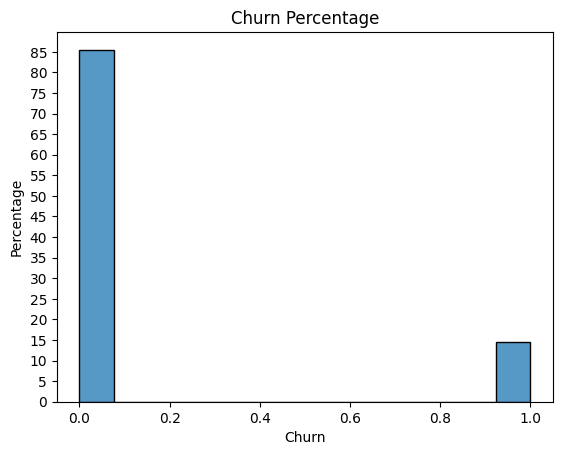

In [6]:
# Таргет
sns.histplot(data=data, x='churn', stat='percent')
ax = plt.gca()
# Задаем шаг равный 5 для меток на оси y
ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
plt.xlabel('Churn')
plt.ylabel('Percentage')
plt.title('Churn Percentage')
plt.show()

* В датасете присутсвует дисбаланс классов 85% и 15%.
* Meтрики ROC AUC, Recall для класса 1, а также confusion matrix могут быть более информативны при дисбалансе классов.


In [7]:
data.select_dtypes(include='object')

,state,phone number,international plan,voice mail plan
0,KS,382-4657,no,yes
1,OH,371-7191,no,yes
2,NJ,358-1921,no,no
3,OH,375-9999,yes,no
4,OK,330-6626,yes,no
...,...,...,...,...
3328,AZ,414-4276,no,yes
3329,WV,370-3271,no,no
3330,RI,328-8230,no,no
3331,CT,364-6381,yes,no


In [8]:
data['international plan'] = data['international plan'].map(lambda x: 1 if x=='yes' else 0)
data['voice mail plan'] = data['voice mail plan'].map(lambda x: 1 if x=='yes' else 0)
data['churn'] = data['churn'].astype(int)#map(lambda x: x.astype(int))

array([[<Axes: title={'center': 'account length'}>,
        <Axes: title={'center': 'area code'}>,
        <Axes: title={'center': 'international plan'}>,
        <Axes: title={'center': 'voice mail plan'}>],
       [<Axes: title={'center': 'number vmail messages'}>,
        <Axes: title={'center': 'total day minutes'}>,
        <Axes: title={'center': 'total day calls'}>,
        <Axes: title={'center': 'total day charge'}>],
       [<Axes: title={'center': 'total eve minutes'}>,
        <Axes: title={'center': 'total eve calls'}>,
        <Axes: title={'center': 'total eve charge'}>,
        <Axes: title={'center': 'total night minutes'}>],
       [<Axes: title={'center': 'total night calls'}>,
        <Axes: title={'center': 'total night charge'}>,
        <Axes: title={'center': 'total intl minutes'}>,
        <Axes: title={'center': 'total intl calls'}>],
       [<Axes: title={'center': 'total intl charge'}>,
        <Axes: title={'center': 'customer service calls'}>,
        <Axe

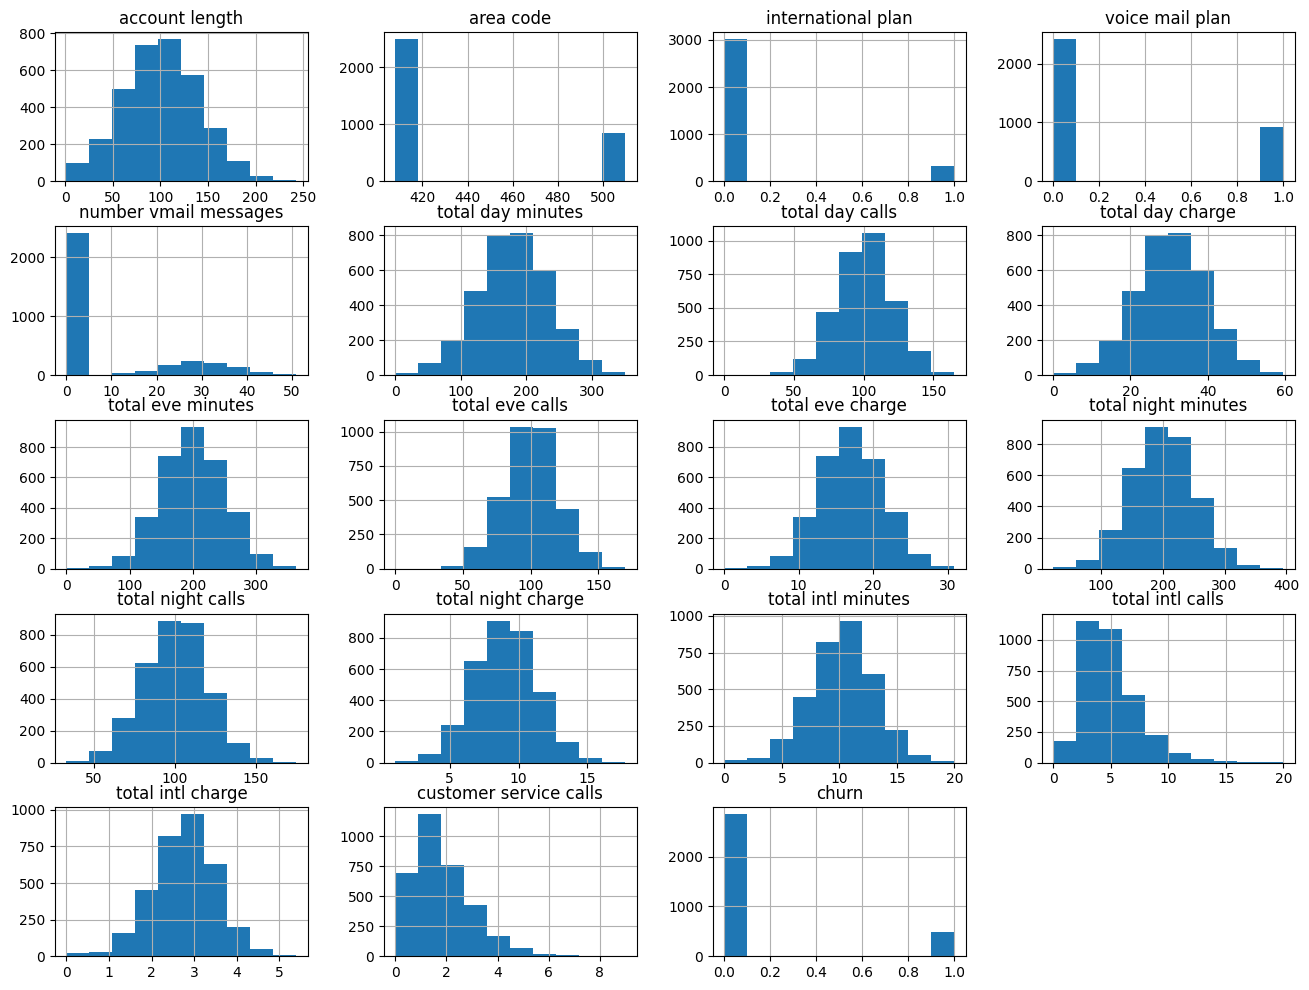

In [9]:
data.hist(figsize=(16, 12))

<Axes: >

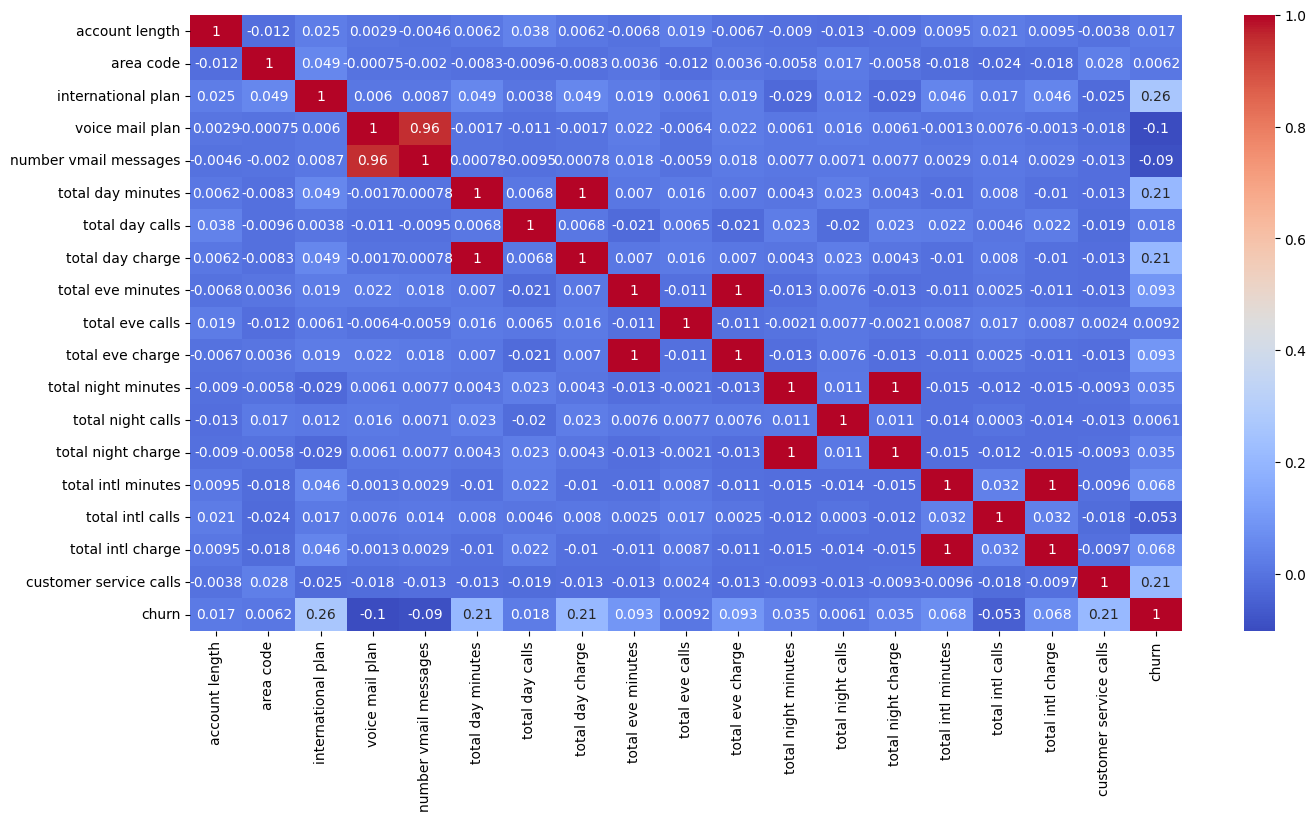

In [10]:
plt.figure(figsize=(16, 8))
sns.heatmap(data=data.drop(['state', 'phone number'], axis=1).corr(), annot=True, cmap='coolwarm')

* Из матрицы видно, что часть признаков имеет сильную корреляцию.Такие признаки могут сильный негативный эффект для линейных моделей, для деревянных моделей это не будет иметь сильного эффекта, но, особенно в случае с большим количеством данных, такие признаки стоит убрать для ускорения вычислений


In [11]:
#здесь же удаляем phone number тк логически номер телефона не будет привносить полезной информации
data.drop(['total day charge', 'total eve minutes', 'total night charge', 'total intl charge', 'phone number'], axis=1, inplace=True)
data

,state,account length,area code,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total eve calls,total eve charge,total night minutes,total night calls,total intl minutes,total intl calls,customer service calls,churn
0,KS,128,415,0,1,25,265.1,110,99,16.78,244.7,91,10.0,3,1,0
1,OH,107,415,0,1,26,161.6,123,103,16.62,254.4,103,13.7,3,1,0
2,NJ,137,415,0,0,0,243.4,114,110,10.30,162.6,104,12.2,5,0,0
3,OH,84,408,1,0,0,299.4,71,88,5.26,196.9,89,6.6,7,2,0
4,OK,75,415,1,0,0,166.7,113,122,12.61,186.9,121,10.1,3,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,AZ,192,415,0,1,36,156.2,77,126,18.32,279.1,83,9.9,6,2,0
3329,WV,68,415,0,0,0,231.1,57,55,13.04,191.3,123,9.6,4,3,0
3330,RI,28,510,0,0,0,180.8,109,58,24.55,191.9,91,14.1,6,2,0
3331,CT,184,510,1,0,0,213.8,105,84,13.57,139.2,137,5.0,10,2,0


In [12]:
data.describe()

,account length,area code,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total eve calls,total eve charge,total night minutes,total night calls,total intl minutes,total intl calls,customer service calls,churn
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,0.096910,0.276628,8.099010,179.775098,100.435644,100.114311,17.083540,200.872037,100.107711,10.237294,4.479448,1.562856,0.144914
std,39.822106,42.371290,0.295879,0.447398,13.688365,54.467389,20.069084,19.922625,4.310668,50.573847,19.568609,2.791840,2.461214,1.315491,0.352067
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,0.000000,0.000000,0.000000,143.700000,87.000000,87.000000,14.160000,167.000000,87.000000,8.500000,3.000000,1.000000,0.000000
50%,101.000000,415.000000,0.000000,0.000000,0.000000,179.400000,101.000000,100.000000,17.120000,201.200000,100.000000,10.300000,4.000000,1.000000,0.000000
75%,127.000000,510.000000,0.000000,1.000000,20.000000,216.400000,114.000000,114.000000,20.000000,235.300000,113.000000,12.100000,6.000000,2.000000,0.000000
max,243.000000,510.000000,1.000000,1.000000,51.000000,350.800000,165.000000,170.000000,30.910000,395.000000,175.000000,20.000000,20.000000,9.000000,1.000000


* Датасет не имеет пропусков и ярко выраженных выбросов

In [13]:
data['area code'].value_counts()

area code
415    1655
510     840
408     838
Name: count, dtype: int64

51

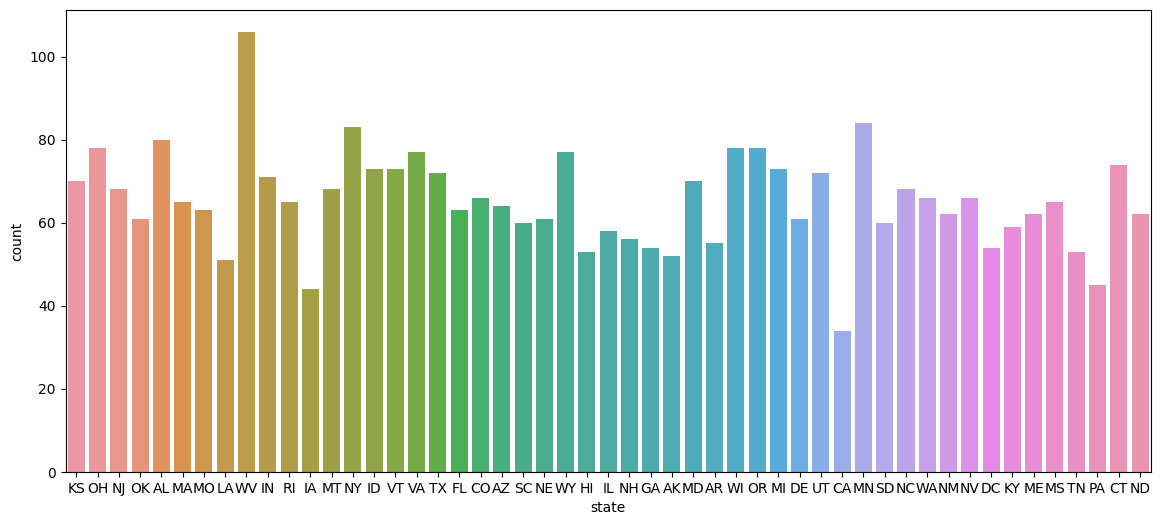

In [14]:
plt.figure(figsize=(14, 6))
sns.countplot(x='state', data=data)
data['state'].nunique()

# Baseline

In [15]:
X = data.drop('churn', axis=1)
y = data['churn'] 

#one hot для колонки area code
X = pd.get_dummies(X, columns=["area code"], prefix=["area_code"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
from sklearn.preprocessing import OneHotEncoder

In [17]:
#Target Encoder
target_encoder = ce.TargetEncoder(cols=['state'])
X_train['state_target'] = target_encoder.fit_transform(X_train['state'], y_train)
X_test['state_target'] = target_encoder.transform(X_test['state'])


In [18]:
X_train

,state,account length,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total eve calls,total eve charge,total night minutes,total night calls,total intl minutes,total intl calls,customer service calls,area_code_408,area_code_415,area_code_510,state_target
817,UT,243,0,0,0,95.5,92,63,13.91,264.2,118,6.6,6,2,False,False,True,0.121184
1373,SC,108,0,0,0,112.0,105,110,16.46,208.9,93,4.1,4,4,False,True,False,0.248264
679,TX,75,1,0,0,222.4,78,111,27.80,208.0,104,8.7,9,1,False,True,False,0.268649
56,CO,141,0,0,0,126.9,98,62,15.30,140.8,128,8.0,2,1,False,True,False,0.123301
1993,IN,86,0,0,0,216.3,96,77,22.64,214.0,110,4.5,3,0,False,False,True,0.171910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,ID,106,0,0,0,274.4,120,82,16.88,160.8,62,6.0,3,1,False,False,True,0.108104
1130,PA,122,0,0,0,35.1,62,89,15.37,251.6,58,12.7,2,1,False,True,False,0.189654
1294,OR,66,0,0,0,87.6,76,111,22.27,184.6,125,9.2,5,1,True,False,False,0.168972
860,HI,169,0,0,0,179.2,111,130,14.89,228.6,92,9.9,6,2,False,True,False,0.068833


In [19]:
features_to_normalize = X_train.columns.difference(['churn', 'state', 'state_encoded', 'international plan', 'voice mail plan', 'area_code_408', 'area_code_415','area_code_510'])
scaler = StandardScaler()
X_train[features_to_normalize] = scaler.fit_transform(X_train[features_to_normalize])
X_test[features_to_normalize] = scaler.transform(X_test[features_to_normalize])


In [20]:
X_train

,state,account length,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total eve calls,total eve charge,total night minutes,total night calls,total intl minutes,total intl calls,customer service calls,area_code_408,area_code_415,area_code_510,state_target
817,UT,3.601382,0,0,-0.584936,-1.547653,-0.429657,-1.840891,-0.731087,1.255804,0.925634,-1.300791,0.634849,0.318978,False,False,True,-0.383973
1373,SC,0.184951,0,0,-0.584936,-1.244014,0.224176,0.499864,-0.139179,0.165090,-0.353704,-2.194793,-0.184370,1.813519,False,True,False,1.843141
679,TX,-0.650176,1,0,-0.584936,0.787609,-1.133785,0.549667,2.493068,0.147339,0.209205,-0.549828,1.863677,-0.428293,False,True,False,2.200391
56,CO,1.020079,0,0,-0.584936,-0.969818,-0.127888,-1.890695,-0.408439,-1.178086,1.437368,-0.800149,-1.003589,-0.428293,False,True,False,-0.346872
1993,IN,-0.371801,0,0,-0.584936,0.675354,-0.228477,-1.143645,1.295326,0.265680,0.516246,-2.051753,-0.593980,-1.175564,False,False,True,0.505016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,ID,0.134337,0,0,-0.584936,1.744532,0.978599,-0.894629,-0.041689,-0.783614,-1.940082,-1.515351,-0.593980,-0.428293,False,False,True,-0.613203
1130,PA,0.539248,0,0,-0.584936,-2.659156,-1.938502,-0.546006,-0.392191,1.007287,-2.144776,0.880576,-1.003589,-0.428293,False,True,False,0.815980
1294,OR,-0.877938,0,0,-0.584936,-1.693032,-1.234374,0.549667,1.209441,-0.314193,1.283848,-0.371028,0.225239,-0.428293,True,False,False,0.453517
860,HI,1.728672,0,0,-0.584936,-0.007374,0.525945,1.495930,-0.503609,0.553644,-0.404877,-0.120707,0.634849,0.318978,False,True,False,-1.301435


In [21]:
#L1 регулизация для отбора признаков
# Создаем экземпляр модели логистической регрессии
logreg_model = LogisticRegression(penalty='l1', solver='liblinear', class_weight='balanced')

# Обучаем модель на тренировочных данных
logreg_model.fit(X_train.drop('state',axis=1), y_train)

# Делаем прогнозы на тестовых данных
y_pred_proba = logreg_model.predict_proba(X_test.drop('state',axis=1))[:, 1] 

# Оцениваем качество модели
roc_auc = roc_auc_score(y_test, y_pred_proba)
y_pred = logreg_model.predict(X_test.drop('state',axis=1))
print("roc_auc:", roc_auc)

def print_roc_curve(y_test, y_pred_proba, roc_auc):
    # Строим ROC-кривую
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label='ROC Curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()



# Выводим отчет по классификации (precision, recall, f1-score и т.д.)
print(classification_report(y_test, y_pred))

# Выводим матрицу ошибок (confusion matrix)
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

roc_auc: 0.8267851520134346
              precision    recall  f1-score   support

           0       0.95      0.77      0.85       566
           1       0.37      0.75      0.50       101

    accuracy                           0.77       667
   macro avg       0.66      0.76      0.67       667
weighted avg       0.86      0.77      0.80       667

Confusion Matrix:
[[438 128]
 [ 25  76]]


In [22]:
logreg_model.coef_

array([[ 4.91076504e-02,  2.32087311e+00, -1.36849246e+00,
         2.35102426e-01,  6.51715392e-01,  0.00000000e+00,
         6.80368309e-03,  2.85837859e-01,  1.34823616e-01,
        -2.92382387e-02,  1.95764708e-01, -1.56657072e-01,
         7.65037354e-01, -1.05572881e-01, -2.57569098e-01,
         8.37388246e-04,  4.36124383e-01]])

roc_auc l2: 0.826050449567925


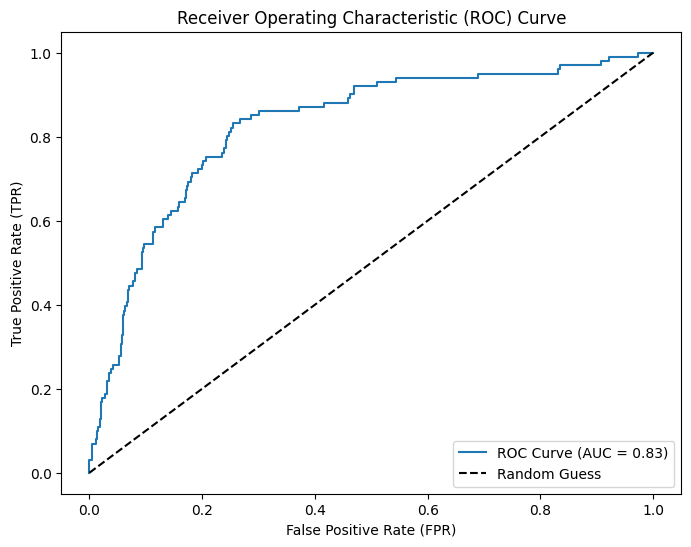

              precision    recall  f1-score   support

           0       0.95      0.78      0.85       566
           1       0.37      0.75      0.50       101

    accuracy                           0.77       667
   macro avg       0.66      0.76      0.68       667
weighted avg       0.86      0.77      0.80       667

Confusion Matrix:
[[439 127]
 [ 25  76]]


In [23]:
# Создаем экземпляр модели логистической регрессии
logreg_model = LogisticRegression(class_weight='balanced', penalty='l2')

# Обучаем модель на тренировочных данных
logreg_model.fit(X_train.drop(['state', 'total day calls', 'area_code_408'],axis=1), y_train)

# Делаем прогнозы на тестовых данных
y_pred_proba_l2 = logreg_model.predict_proba(X_test.drop(['state', 'total day calls', 'area_code_408'],axis=1))[:, 1] 
y_pred_l2 = logreg_model.predict(X_test.drop(['state', 'total day calls', 'area_code_408'],axis=1))

# Оцениваем качество модели
roc_auc = roc_auc_score(y_test, y_pred_proba_l2)
print("roc_auc l2:", roc_auc)
print_roc_curve(y_test, y_pred_proba_l2, roc_auc)
# Выводим отчет по классификации (precision, recall, f1-score и т.д.)
print(classification_report(y_test, y_pred_l2))

# Выводим матрицу ошибок (confusion matrix)
conf_matrix = confusion_matrix(y_test, y_pred_l2)
print("Confusion Matrix:")
print(conf_matrix)

roc_auc: 0.9291361998390651


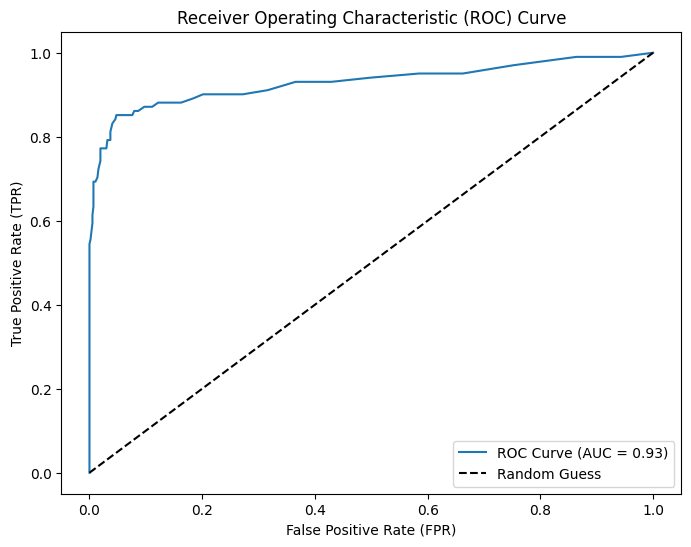

              precision    recall  f1-score   support

           0       0.94      0.99      0.96       566
           1       0.94      0.63      0.76       101

    accuracy                           0.94       667
   macro avg       0.94      0.81      0.86       667
weighted avg       0.94      0.94      0.93       667

Confusion Matrix:
[[562   4]
 [ 37  64]]


In [24]:
# Создаем и обучаем модель Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train.drop(['state', 'total day calls', 'area_code_408'],axis=1), y_train)

# Делаем прогнозы на тестовых данных
y_pred_rf = rf_model.predict(X_test.drop(['state', 'total day calls', 'area_code_408'],axis=1))
y_pred_proba_rf = rf_model.predict_proba(X_test.drop(['state', 'total day calls', 'area_code_408'],axis=1))[:, 1]

# Оцениваем качество модели
roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf)
print("roc_auc:", roc_auc_rf)
print_roc_curve(y_test, y_pred_proba_rf, roc_auc_rf)

# Выводим отчет по классификации (precision, recall, f1-score и т.д.)
print(classification_report(y_test, y_pred_rf))

# Выводим матрицу ошибок (confusion matrix)
conf_matrix = confusion_matrix(y_test, y_pred_rf)
print("Confusion Matrix:")
print(conf_matrix)

roc_auc: 0.7849858307385509


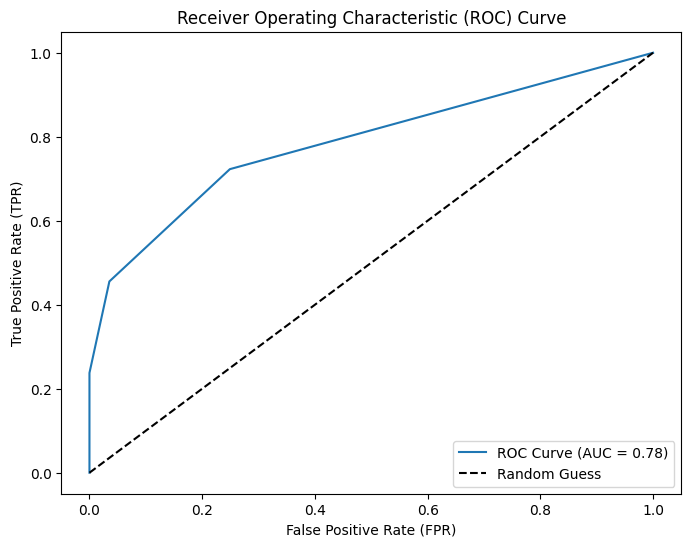

In [25]:
# Создаем и обучаем модель K-Nearest Neighbors (KNN)
knn_model = KNeighborsClassifier()
knn_model.fit(X_train.drop(['state','total day calls', 'area_code_408'],axis=1), y_train)
y_pred_knn = knn_model.predict(X_test.drop(['state', 'total day calls', 'area_code_408'],axis=1))
y_pred_proba_knn = knn_model.predict_proba(X_test.drop(['state', 'total day calls', 'area_code_408'],axis=1))[:, 1]
# Оцениваем качество модели
roc_auc_knn = roc_auc_score(y_test, y_pred_proba_knn)
print("roc_auc:", roc_auc_knn)
print_roc_curve(y_test, y_pred_proba_knn, roc_auc_knn)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 382, number of negative: 2284
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000162 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1433
[LightGBM] [Info] Number of data points in the train set: 2666, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.143286 -> initscore=-1.788263
[LightGBM] [Info] Start training from score -1.788263
roc_auc: 0.9243256481125144


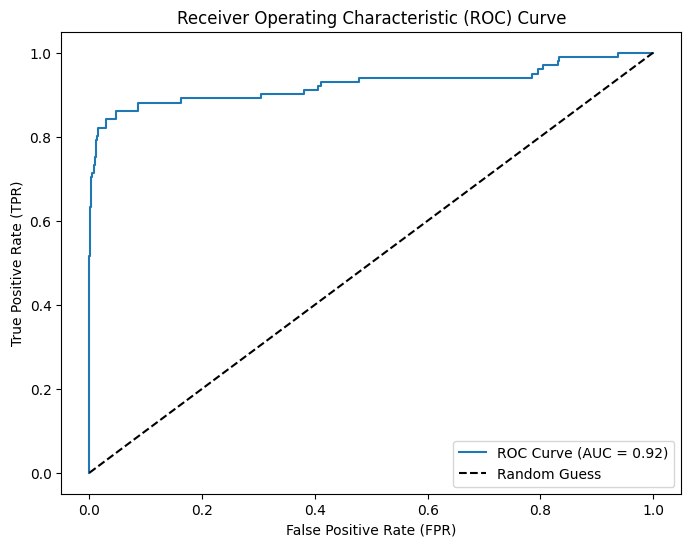

In [26]:
# Создаем и обучаем модель LightGBM
lgb_model = lgb.LGBMClassifier(random_state=42)
lgb_model.fit(X_train.drop(['state', 'total day calls', 'area_code_408'],axis=1), y_train)
y_pred_lgb = lgb_model.predict(X_test.drop(['state', 'total day calls', 'area_code_408'],axis=1))

y_pred_proba_lgb = lgb_model.predict_proba(X_test.drop(['state', 'total day calls', 'area_code_408'],axis=1))[:, 1]
# Оцениваем качество модели
roc_auc_lgb = roc_auc_score(y_test, y_pred_proba_lgb)
print("roc_auc:", roc_auc_lgb)
print_roc_curve(y_test, y_pred_proba_lgb, roc_auc_lgb)

roc_auc: 0.9203372634083196


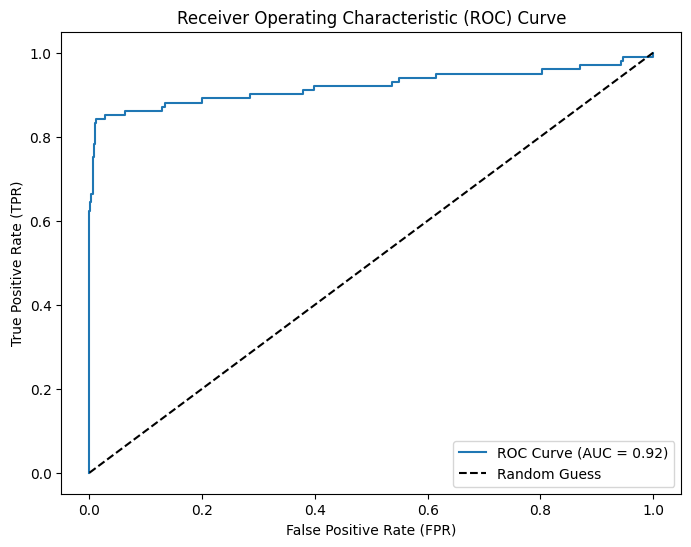

In [27]:
# Создаем и обучаем модель XGBoost
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_train.drop(['state', 'total day calls', 'area_code_408'],axis=1), y_train)
y_pred_proba_xgb = xgb_model.predict_proba(X_test.drop(['state', 'total day calls', 'area_code_408'],axis=1))[:, 1]

# Оцениваем качество модели
roc_auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)
print("roc_auc:", roc_auc_xgb)
print_roc_curve(y_test, y_pred_proba_xgb, roc_auc_xgb)

roc_auc: 0.937182940908932


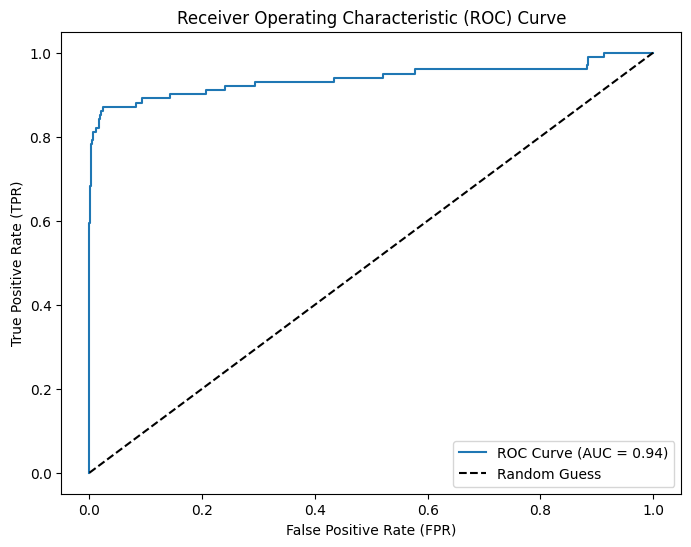

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       566
           1       0.98      0.78      0.87       101

    accuracy                           0.96       667
   macro avg       0.97      0.89      0.92       667
weighted avg       0.96      0.96      0.96       667

Confusion Matrix:
[[564   2]
 [ 22  79]]


In [28]:
# Создаем и обучаем модель CatBoost
cb_model = cb.CatBoostClassifier(random_seed=42, verbose=0)
cb_model.fit(X_train.drop(['state', 'total day calls', 'area_code_408'],axis=1), y_train)
y_pred_cb = cb_model.predict(X_test.drop(['state', 'total day calls', 'area_code_408'],axis=1))
y_pred_proba_cb = cb_model.predict_proba(X_test.drop(['state', 'total day calls', 'area_code_408'],axis=1))[:, 1]
# Оцениваем качество модели
roc_auc_cb = roc_auc_score(y_test, y_pred_proba_cb)
print("roc_auc:", roc_auc_cb)
print_roc_curve(y_test, y_pred_proba_cb, roc_auc_cb)
# Выводим отчет по классификации (precision, recall, f1-score и т.д.)
print(classification_report(y_test, y_pred_cb))
# Выводим матрицу ошибок (confusion matrix)
conf_matrix = confusion_matrix(y_test, y_pred_cb)
print("Confusion Matrix:")
print(conf_matrix)


roc_auc: 0.9291361998390651


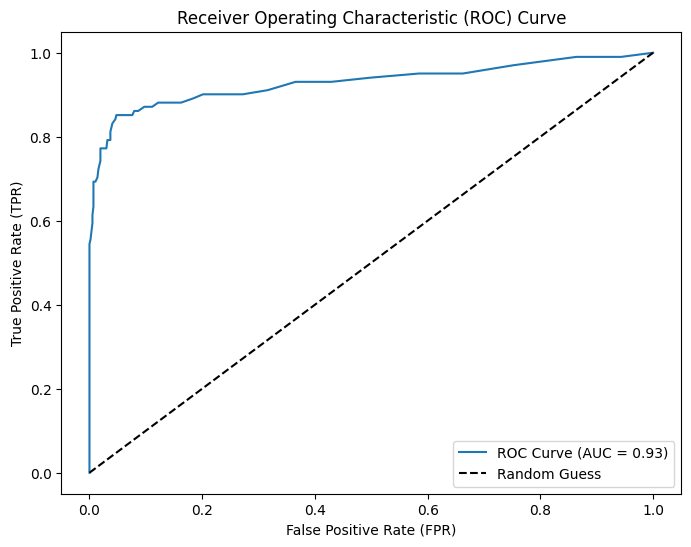

              precision    recall  f1-score   support

           0       0.94      0.99      0.96       566
           1       0.94      0.63      0.76       101

    accuracy                           0.94       667
   macro avg       0.94      0.81      0.86       667
weighted avg       0.94      0.94      0.93       667

Confusion Matrix:
[[562   4]
 [ 37  64]]


In [29]:
print("roc_auc:", roc_auc_rf)
print_roc_curve(y_test, y_pred_proba_rf, roc_auc_rf)
# Выводим отчет по классификации (precision, recall, f1-score и т.д.)
print(classification_report(y_test, y_pred_rf))
conf_matrix = confusion_matrix(y_test, y_pred_rf)
print("Confusion Matrix:")
print(conf_matrix)

Наилучшие результаты показадис модели Random Forest и CatBoost.

Обе модели показывают хорошие результаты по ROC AUC, однако Recall для положительного класса у Random Forest сооставляет 0.63 против 0.78 у CatBoost

Это говорит о том, что CatBoost гораздо лучше  правильно индентифицирует положительные случаи.

* Проврим важность оставшихся фичей, введя случайный признак 

In [30]:
random_feature_train = np.random.rand(X_train.shape[0])
random_feature_test = np.random.rand(X_test.shape[0])
X_train['random_feature'] = random_feature_train
X_test['random_feature'] = random_feature_test

In [31]:
# Определим количество разбиений для кросс-валидации
n_splits = 7

# Инициализируем пустой список для сохранения менее важных признаков
less_important_features_list = []

# Выполним кросс-валидацию и запишем менее важные признаки для каждого разбиения
kf = KFold(n_splits=n_splits, random_state=42, shuffle=True)
for train_index, _ in kf.split(X_train):
    X_train_cv, _, y_train_cv, _ = X_train.iloc[train_index], X_train.iloc[~train_index], y_train.iloc[train_index], y_train.iloc[~train_index]

    # CatBoost 
    cb_model_cv = cb.CatBoostClassifier(random_seed=42, verbose=0)
    cb_model_cv.fit(X_train_cv.drop(['state', 'total day calls', 'area_code_408'], axis=1), y_train_cv)

    # Получим значимость случайного признака для текущего разбиения
    features = X_train.drop(['state', 'total day calls', 'area_code_408'], axis=1).columns
    random_feature_importance_cv = cb_model_cv.feature_importances_[-1]
    indices = np.argsort(random_feature_importance_cv)

    # Отфильтруем признаки с значимостью меньше значимости случайного признака для текущего разбиения
    less_important_features_cv = [features[i] for i in indices if cb_model_cv.feature_importances_[i] <= random_feature_importance_cv]
    less_important_features_list.extend(less_important_features_cv)
    print(less_important_features_list)

# Количество вхождений каждого признака в списке
feature_counts = pd.Series(less_important_features_list).value_counts()

# Окончательный список менее важных признаков (признаки которые были не важны на каждой итерации)
final_less_important_features = feature_counts[feature_counts == n_splits].index.tolist()


print("Features with importances consistently less than the random feature:")
print(final_less_important_features)

X_train.drop('random_feature', axis=1, inplace=True)
X_test.drop('random_feature', axis=1, inplace=True)

[]
[]
[]
[]
['account length']
['account length']
['account length']
Features with importances consistently less than the random feature:
[]


* Признак account length часто оказывается менее значимым чем случайная величина

# Подбор параметров

In [32]:
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
        'depth': trial.suggest_int('depth', 3, 9),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10, log=True),
        'random_seed': 42,
        'border_count': trial.suggest_int('border_count', 32, 128),
        'verbose': 0,
    }
    
    cb_model = cb.CatBoostClassifier(**params)
    cb_model.fit(X_train.drop(['state', 'total day calls', 'area_code_408', 'account length'],axis=1), y_train)
    y_pred_proba = cb_model.predict_proba(X_test.drop(['state', 'total day calls', 'area_code_408', 'account length'],axis=1))[:, 1]
    

    roc_auc = roc_auc_score(y_test, y_pred_proba)
    return roc_auc


# Создаем объект study и запускаем оптимизацию
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
# Получаем лучшие параметры
best_params = study.best_params
print("Best Parameters:")
print(best_params)
# Выводим результаты оптимизации
print("Number of finished trials:", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-08-16 22:33:41,470] A new study created in memory with name: no-name-03f3397d-4585-4877-ba8d-e1db9d8bd9ff
[I 2023-08-16 22:33:42,230] Trial 0 finished with value: 0.9215617674841691 and parameters: {'iterations': 991, 'learning_rate': 0.005972667573125914, 'depth': 7, 'l2_leaf_reg': 0.03594375596751397, 'border_count': 49}. Best is trial 0 with value: 0.9215617674841691.
[I 2023-08-16 22:33:42,637] Trial 1 finished with value: 0.9281565965783858 and parameters: {'iterations': 264, 'learning_rate': 0.007851982491055395, 'depth': 9, 'l2_leaf_reg': 1.2716002055875675, 'border_count': 66}. Best is trial 1 with value: 0.9281565965783858.
[I 2023-08-16 22:33:43,122] Trial 2 finished with value: 0.9233460448518349 and parameters: {'iterations': 663, 'learning_rate': 0.004417526166607429, 'depth': 5, 'l2_leaf_reg': 2.3552273472264122, 'border_count': 61}. Best is trial 1 with value: 0.9281565965783858.
[I 2023-08-16 22:33:44,190] Trial 3 finished with value: 0.9227162998985412 and para

Best Parameters:
{'iterations': 522, 'learning_rate': 0.04481912260580229, 'depth': 7, 'l2_leaf_reg': 7.679207483924863, 'border_count': 113}
Number of finished trials: 100
Best trial:
  Value: 0.9494979533289019
  Params: 
    iterations: 522
    learning_rate: 0.04481912260580229
    depth: 7
    l2_leaf_reg: 7.679207483924863
    border_count: 113


In [33]:
best_params= {'iterations': 855,
 'learning_rate': 0.0795681338947631,
 'depth': 8,
 'l2_leaf_reg': 7.604927855786209,
 'border_count': 108}

roc_auc: 0.946524157716125


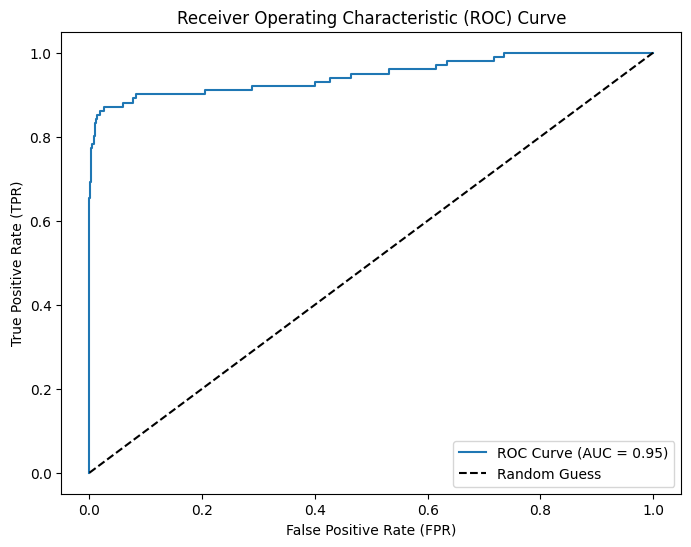

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       566
           1       0.93      0.83      0.88       101

    accuracy                           0.97       667
   macro avg       0.95      0.91      0.93       667
weighted avg       0.96      0.97      0.96       667

Confusion Matrix:
[[560   6]
 [ 17  84]]


In [34]:
# Создаем и обучаем модель CatBoost
cb_model = cb.CatBoostClassifier(**best_params, verbose=0, random_seed = 42)
cb_model.fit(X_train.drop(['state', 'total day calls', 'area_code_408', 'account length'],axis=1), y_train)
y_pred_cb = cb_model.predict(X_test.drop(['state', 'total day calls', 'area_code_408', 'account length'],axis=1))
y_pred_proba_cb = cb_model.predict_proba(X_test.drop(['state', 'total day calls', 'area_code_408', 'account length'],axis=1))[:, 1]
# Оцениваем качество модели
roc_auc_cb = roc_auc_score(y_test, y_pred_proba_cb)
print("roc_auc:", roc_auc_cb)
print_roc_curve(y_test, y_pred_proba_cb, roc_auc_cb)
# Выводим отчет по классификации (precision, recall, f1-score и т.д.)
print(classification_report(y_test, y_pred_cb))
# Выводим матрицу ошибок (confusion matrix)
conf_matrix = confusion_matrix(y_test, y_pred_cb)
print("Confusion Matrix:")
print(conf_matrix)

# ROC AUC: 
* Значение 0.9427 говорит о том, что в целом модель хорошо разделяет классы

# Precision:
*  Для класса 1 (положительного класса) точность составляет 0.93, что означает, что  около 93% предсказаний, которые модель отнесла к классу 1, были правильными.
# Recall:
*  Полнота для класса 1 составляет 0.81, что означает, что модель обнаруживает около 83% всех реальных экземпляров класса 1.